In [2]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

# Add project root to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import from base_script.py (which is in the root folder)
from base_script import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    compute_condition_distances
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sub_cond_path = '../subject_info.xlsx'
base_nifti_folder = '../data_FC'
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [6]:
# Load and preprocess
use_roi = 0
all_corr_data, all_tms_type, all_subject_id, all_stimloc, all_session = load_all_fc_data(sub_cond_path, 
                                                               base_nifti_folder, 
                                                               mat_filename='conn_matrix_w_sphere.mat',
                                                               key_name='correlation_matrix',row_idx=use_roi)
X_tensor = preprocess_for_torch(all_corr_data)


[WARN] File not found: ../data_FC/NODEAP_30/S3D2/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_44/S1D1/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_83/S3D1/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_87/D0/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_88/D0/conn_matrix_w_sphere.mat
Columns with NaN: 14 / 116
Tensor shape after preprocessing: torch.Size([331, 102])


In [7]:
condition_list = np.array([condition_map[t] for t in all_tms_type]) # map tms type to 0,1,2
condition_tensor = torch.tensor(condition_list, dtype=torch.long)

# Create unique key: subject + condition
combo_keys = np.array([f"{s}_{c}" for s, c in zip(all_subject_id, condition_list)])
combo_counts = Counter(combo_keys)

weights = np.array([1.0 / combo_counts[k] for k in combo_keys]) # assign weights based on counts
weights_tensor = torch.DoubleTensor(weights) # convert to torch tensor

le = LabelEncoder()
subject_labels = le.fit_transform(all_subject_id)
subject_tensor = torch.tensor(subject_labels, dtype=torch.long)

In [8]:
dataset = TensorDataset(X_tensor, subject_tensor, condition_tensor)
# create a weighted sampler that draws samples w/ prob proportional to weight
sampler = WeightedRandomSampler(weights_tensor, num_samples=len(weights_tensor), replacement=True)
# create a dataloader using the sampler instead of random shuffle
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

In [10]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
latent_dim = 10
NUM_EPOCH = 500
LR = 3e-4
model = VAE(input_dim=input_dim, latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=DEVICE, epochs=NUM_EPOCH)


===== Epoch 1 =====


Epoch 1/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1007.50it/s]


Epoch 1, Loss: 106.6715, Recon: 106.3371, KL: 0.3345

===== Epoch 2 =====


Epoch 2/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1058.39it/s]


Epoch 2, Loss: 103.3215, Recon: 102.6841, KL: 0.6374

===== Epoch 3 =====


Epoch 3/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1185.35it/s]


Epoch 3, Loss: 101.5223, Recon: 100.2019, KL: 1.3204

===== Epoch 4 =====


Epoch 4/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1083.44it/s]


Epoch 4, Loss: 88.7064, Recon: 86.3286, KL: 2.3778

===== Epoch 5 =====


Epoch 5/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1029.48it/s]


Epoch 5, Loss: 83.0527, Recon: 77.8926, KL: 5.1601

===== Epoch 6 =====


Epoch 6/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 350.86it/s]


Epoch 6, Loss: 75.2689, Recon: 67.8965, KL: 7.3724

===== Epoch 7 =====


Epoch 7/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 718.49it/s]


Epoch 7, Loss: 72.1145, Recon: 64.1295, KL: 7.9850

===== Epoch 8 =====


Epoch 8/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1094.31it/s]


Epoch 8, Loss: 63.3841, Recon: 55.1917, KL: 8.1924

===== Epoch 9 =====


Epoch 9/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1159.99it/s]


Epoch 9, Loss: 61.5827, Recon: 53.3253, KL: 8.2574

===== Epoch 10 =====


Epoch 10/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1087.71it/s]


Epoch 10, Loss: 57.9434, Recon: 50.0971, KL: 7.8463

===== Epoch 11 =====


Epoch 11/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 950.56it/s]


Epoch 11, Loss: 56.6880, Recon: 48.0422, KL: 8.6458

===== Epoch 12 =====


Epoch 12/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 990.73it/s]


Epoch 12, Loss: 55.9710, Recon: 47.3584, KL: 8.6126

===== Epoch 13 =====


Epoch 13/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1010.92it/s]


Epoch 13, Loss: 53.7707, Recon: 44.6573, KL: 9.1135

===== Epoch 14 =====


Epoch 14/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1015.73it/s]


Epoch 14, Loss: 52.9841, Recon: 43.6964, KL: 9.2877

===== Epoch 15 =====


Epoch 15/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1089.87it/s]


Epoch 15, Loss: 51.8486, Recon: 42.9167, KL: 8.9320

===== Epoch 16 =====


Epoch 16/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1119.59it/s]


Epoch 16, Loss: 50.5537, Recon: 41.5423, KL: 9.0114

===== Epoch 17 =====


Epoch 17/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1066.41it/s]


Epoch 17, Loss: 51.4011, Recon: 41.7787, KL: 9.6224

===== Epoch 18 =====


Epoch 18/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1123.96it/s]


Epoch 18, Loss: 49.4600, Recon: 40.2698, KL: 9.1902

===== Epoch 19 =====


Epoch 19/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1003.01it/s]


Epoch 19, Loss: 47.8054, Recon: 37.7472, KL: 10.0582

===== Epoch 20 =====


Epoch 20/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1015.79it/s]


Epoch 20, Loss: 47.0204, Recon: 37.1442, KL: 9.8762

===== Epoch 21 =====


Epoch 21/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1015.59it/s]


Epoch 21, Loss: 45.0714, Recon: 35.2384, KL: 9.8330

===== Epoch 22 =====


Epoch 22/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1034.31it/s]


Epoch 22, Loss: 47.0075, Recon: 36.7552, KL: 10.2522

===== Epoch 23 =====


Epoch 23/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1140.83it/s]


Epoch 23, Loss: 48.2293, Recon: 37.9393, KL: 10.2900

===== Epoch 24 =====


Epoch 24/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1126.46it/s]


Epoch 24, Loss: 47.1921, Recon: 36.6014, KL: 10.5907

===== Epoch 25 =====


Epoch 25/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1019.75it/s]


Epoch 25, Loss: 45.9016, Recon: 35.3139, KL: 10.5877

===== Epoch 26 =====


Epoch 26/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1053.53it/s]


Epoch 26, Loss: 45.7180, Recon: 35.1062, KL: 10.6118

===== Epoch 27 =====


Epoch 27/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1080.53it/s]


Epoch 27, Loss: 44.7106, Recon: 34.3686, KL: 10.3420

===== Epoch 28 =====


Epoch 28/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1076.44it/s]


Epoch 28, Loss: 44.3273, Recon: 33.5378, KL: 10.7895

===== Epoch 29 =====


Epoch 29/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1076.42it/s]


Epoch 29, Loss: 43.5494, Recon: 32.9260, KL: 10.6234

===== Epoch 30 =====


Epoch 30/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1199.56it/s]


Epoch 30, Loss: 42.7752, Recon: 32.3928, KL: 10.3824

===== Epoch 31 =====


Epoch 31/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1239.02it/s]


Epoch 31, Loss: 41.2455, Recon: 31.0129, KL: 10.2326

===== Epoch 32 =====


Epoch 32/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1225.53it/s]


Epoch 32, Loss: 42.6773, Recon: 31.5269, KL: 11.1504

===== Epoch 33 =====


Epoch 33/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1193.60it/s]


Epoch 33, Loss: 41.6050, Recon: 30.8586, KL: 10.7464

===== Epoch 34 =====


Epoch 34/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1250.44it/s]


Epoch 34, Loss: 41.6790, Recon: 30.9662, KL: 10.7128

===== Epoch 35 =====


Epoch 35/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1114.24it/s]


Epoch 35, Loss: 41.7086, Recon: 30.9506, KL: 10.7580

===== Epoch 36 =====


Epoch 36/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1220.44it/s]


Epoch 36, Loss: 42.5743, Recon: 31.1459, KL: 11.4284

===== Epoch 37 =====


Epoch 37/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1150.61it/s]


Epoch 37, Loss: 40.9399, Recon: 30.1494, KL: 10.7904

===== Epoch 38 =====


Epoch 38/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1223.96it/s]


Epoch 38, Loss: 41.8572, Recon: 30.9402, KL: 10.9170

===== Epoch 39 =====


Epoch 39/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1025.46it/s]


Epoch 39, Loss: 41.2709, Recon: 30.4113, KL: 10.8597

===== Epoch 40 =====


Epoch 40/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1234.84it/s]


Epoch 40, Loss: 40.7358, Recon: 29.9093, KL: 10.8265

===== Epoch 41 =====


Epoch 41/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1256.12it/s]


Epoch 41, Loss: 41.2778, Recon: 29.5938, KL: 11.6839

===== Epoch 42 =====


Epoch 42/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1175.44it/s]


Epoch 42, Loss: 41.2066, Recon: 29.9011, KL: 11.3055

===== Epoch 43 =====


Epoch 43/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1154.10it/s]


Epoch 43, Loss: 39.5712, Recon: 28.8907, KL: 10.6805

===== Epoch 44 =====


Epoch 44/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1245.74it/s]


Epoch 44, Loss: 40.8269, Recon: 29.5700, KL: 11.2568

===== Epoch 45 =====


Epoch 45/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1078.73it/s]


Epoch 45, Loss: 39.9781, Recon: 28.4665, KL: 11.5115

===== Epoch 46 =====


Epoch 46/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1318.29it/s]


Epoch 46, Loss: 40.8647, Recon: 29.4740, KL: 11.3907

===== Epoch 47 =====


Epoch 47/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1247.60it/s]


Epoch 47, Loss: 39.9369, Recon: 28.6190, KL: 11.3179

===== Epoch 48 =====


Epoch 48/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1218.31it/s]


Epoch 48, Loss: 40.5192, Recon: 29.3518, KL: 11.1674

===== Epoch 49 =====


Epoch 49/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1289.73it/s]


Epoch 49, Loss: 38.4729, Recon: 27.1391, KL: 11.3338

===== Epoch 50 =====


Epoch 50/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1174.34it/s]


Epoch 50, Loss: 39.6672, Recon: 28.0839, KL: 11.5833

===== Epoch 51 =====


Epoch 51/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1277.87it/s]


Epoch 51, Loss: 39.9324, Recon: 28.4229, KL: 11.5095

===== Epoch 52 =====


Epoch 52/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1140.71it/s]


Epoch 52, Loss: 39.5539, Recon: 28.0106, KL: 11.5433

===== Epoch 53 =====


Epoch 53/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1184.71it/s]


Epoch 53, Loss: 39.1830, Recon: 27.4726, KL: 11.7104

===== Epoch 54 =====


Epoch 54/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1269.50it/s]


Epoch 54, Loss: 39.2777, Recon: 27.1832, KL: 12.0946

===== Epoch 55 =====


Epoch 55/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1327.66it/s]


Epoch 55, Loss: 37.6314, Recon: 26.0143, KL: 11.6172

===== Epoch 56 =====


Epoch 56/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1169.72it/s]


Epoch 56, Loss: 37.9433, Recon: 26.4910, KL: 11.4523

===== Epoch 57 =====


Epoch 57/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1071.47it/s]


Epoch 57, Loss: 37.9065, Recon: 26.2391, KL: 11.6674

===== Epoch 58 =====


Epoch 58/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1271.84it/s]


Epoch 58, Loss: 37.8347, Recon: 25.9188, KL: 11.9158

===== Epoch 59 =====


Epoch 59/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1043.57it/s]


Epoch 59, Loss: 38.2876, Recon: 26.0051, KL: 12.2825

===== Epoch 60 =====


Epoch 60/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1214.01it/s]


Epoch 60, Loss: 38.1400, Recon: 25.9964, KL: 12.1436

===== Epoch 61 =====


Epoch 61/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1095.40it/s]


Epoch 61, Loss: 36.7296, Recon: 25.4952, KL: 11.2344

===== Epoch 62 =====


Epoch 62/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 910.01it/s]


Epoch 62, Loss: 37.4805, Recon: 25.3532, KL: 12.1273

===== Epoch 63 =====


Epoch 63/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1215.61it/s]


Epoch 63, Loss: 37.0952, Recon: 24.7685, KL: 12.3267

===== Epoch 64 =====


Epoch 64/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1351.53it/s]


Epoch 64, Loss: 36.5277, Recon: 24.8397, KL: 11.6880

===== Epoch 65 =====


Epoch 65/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1014.12it/s]


Epoch 65, Loss: 37.1237, Recon: 25.1675, KL: 11.9562

===== Epoch 66 =====


Epoch 66/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1253.80it/s]


Epoch 66, Loss: 36.3171, Recon: 24.4632, KL: 11.8539

===== Epoch 67 =====


Epoch 67/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1213.76it/s]


Epoch 67, Loss: 35.9371, Recon: 23.9514, KL: 11.9857

===== Epoch 68 =====


Epoch 68/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 909.93it/s]


Epoch 68, Loss: 35.9977, Recon: 23.9754, KL: 12.0222

===== Epoch 69 =====


Epoch 69/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1273.70it/s]


Epoch 69, Loss: 37.2587, Recon: 24.9797, KL: 12.2790

===== Epoch 70 =====


Epoch 70/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1327.54it/s]


Epoch 70, Loss: 37.3027, Recon: 25.1831, KL: 12.1195

===== Epoch 71 =====


Epoch 71/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1306.60it/s]


Epoch 71, Loss: 36.4092, Recon: 23.9035, KL: 12.5058

===== Epoch 72 =====


Epoch 72/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1246.05it/s]


Epoch 72, Loss: 36.0526, Recon: 23.5380, KL: 12.5146

===== Epoch 73 =====


Epoch 73/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1263.34it/s]


Epoch 73, Loss: 35.8389, Recon: 23.5054, KL: 12.3336

===== Epoch 74 =====


Epoch 74/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1259.04it/s]


Epoch 74, Loss: 35.0761, Recon: 23.6416, KL: 11.4345

===== Epoch 75 =====


Epoch 75/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1275.32it/s]


Epoch 75, Loss: 35.8828, Recon: 23.5274, KL: 12.3553

===== Epoch 76 =====


Epoch 76/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1211.84it/s]


Epoch 76, Loss: 36.6119, Recon: 24.0973, KL: 12.5146

===== Epoch 77 =====


Epoch 77/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1292.15it/s]


Epoch 77, Loss: 35.9625, Recon: 23.4435, KL: 12.5189

===== Epoch 78 =====


Epoch 78/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1250.98it/s]


Epoch 78, Loss: 35.6644, Recon: 23.3238, KL: 12.3406

===== Epoch 79 =====


Epoch 79/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1216.00it/s]


Epoch 79, Loss: 36.0852, Recon: 23.6460, KL: 12.4392

===== Epoch 80 =====


Epoch 80/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1195.76it/s]


Epoch 80, Loss: 34.2346, Recon: 21.9328, KL: 12.3019

===== Epoch 81 =====


Epoch 81/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1076.74it/s]


Epoch 81, Loss: 35.3100, Recon: 22.8195, KL: 12.4905

===== Epoch 82 =====


Epoch 82/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1259.31it/s]


Epoch 82, Loss: 34.9494, Recon: 22.8759, KL: 12.0735

===== Epoch 83 =====


Epoch 83/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1255.16it/s]


Epoch 83, Loss: 36.1933, Recon: 23.3983, KL: 12.7950

===== Epoch 84 =====


Epoch 84/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1144.02it/s]


Epoch 84, Loss: 33.7559, Recon: 21.8999, KL: 11.8561

===== Epoch 85 =====


Epoch 85/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1014.77it/s]


Epoch 85, Loss: 35.1123, Recon: 22.7252, KL: 12.3871

===== Epoch 86 =====


Epoch 86/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1048.53it/s]


Epoch 86, Loss: 35.2370, Recon: 23.1546, KL: 12.0825

===== Epoch 87 =====


Epoch 87/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1046.72it/s]


Epoch 87, Loss: 34.9275, Recon: 22.0810, KL: 12.8465

===== Epoch 88 =====


Epoch 88/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1160.98it/s]


Epoch 88, Loss: 35.4396, Recon: 22.6962, KL: 12.7434

===== Epoch 89 =====


Epoch 89/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 969.15it/s]


Epoch 89, Loss: 34.5602, Recon: 22.4269, KL: 12.1332

===== Epoch 90 =====


Epoch 90/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1245.17it/s]


Epoch 90, Loss: 34.6914, Recon: 22.3161, KL: 12.3753

===== Epoch 91 =====


Epoch 91/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1260.31it/s]


Epoch 91, Loss: 35.0955, Recon: 22.3765, KL: 12.7190

===== Epoch 92 =====


Epoch 92/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1199.68it/s]


Epoch 92, Loss: 35.0191, Recon: 22.5192, KL: 12.4999

===== Epoch 93 =====


Epoch 93/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1276.70it/s]


Epoch 93, Loss: 34.4831, Recon: 21.9983, KL: 12.4847

===== Epoch 94 =====


Epoch 94/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1209.46it/s]


Epoch 94, Loss: 34.1504, Recon: 21.6005, KL: 12.5499

===== Epoch 95 =====


Epoch 95/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1318.32it/s]


Epoch 95, Loss: 34.2092, Recon: 22.1604, KL: 12.0488

===== Epoch 96 =====


Epoch 96/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1271.98it/s]


Epoch 96, Loss: 35.8261, Recon: 22.6059, KL: 13.2202

===== Epoch 97 =====


Epoch 97/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1238.05it/s]


Epoch 97, Loss: 34.1698, Recon: 21.9235, KL: 12.2463

===== Epoch 98 =====


Epoch 98/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1314.19it/s]


Epoch 98, Loss: 34.4450, Recon: 21.6350, KL: 12.8100

===== Epoch 99 =====


Epoch 99/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1111.31it/s]


Epoch 99, Loss: 34.5158, Recon: 22.2055, KL: 12.3103

===== Epoch 100 =====


Epoch 100/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1284.63it/s]


Epoch 100, Loss: 34.5727, Recon: 22.0406, KL: 12.5321

===== Epoch 101 =====


Epoch 101/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1039.50it/s]


Epoch 101, Loss: 34.5194, Recon: 22.0277, KL: 12.4917

===== Epoch 102 =====


Epoch 102/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.62it/s]


Epoch 102, Loss: 35.0424, Recon: 22.1691, KL: 12.8733

===== Epoch 103 =====


Epoch 103/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1260.31it/s]


Epoch 103, Loss: 33.4978, Recon: 20.8321, KL: 12.6657

===== Epoch 104 =====


Epoch 104/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.52it/s]


Epoch 104, Loss: 33.2706, Recon: 20.8744, KL: 12.3963

===== Epoch 105 =====


Epoch 105/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1282.20it/s]


Epoch 105, Loss: 34.5038, Recon: 21.4622, KL: 13.0416

===== Epoch 106 =====


Epoch 106/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1289.76it/s]


Epoch 106, Loss: 34.4533, Recon: 22.3407, KL: 12.1127

===== Epoch 107 =====


Epoch 107/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1139.93it/s]


Epoch 107, Loss: 33.5418, Recon: 21.1509, KL: 12.3910

===== Epoch 108 =====


Epoch 108/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1095.07it/s]


Epoch 108, Loss: 34.1460, Recon: 21.5810, KL: 12.5650

===== Epoch 109 =====


Epoch 109/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1334.30it/s]


Epoch 109, Loss: 33.6014, Recon: 21.2294, KL: 12.3719

===== Epoch 110 =====


Epoch 110/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1324.80it/s]


Epoch 110, Loss: 33.9245, Recon: 21.6738, KL: 12.2507

===== Epoch 111 =====


Epoch 111/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.12it/s]


Epoch 111, Loss: 33.6331, Recon: 21.2942, KL: 12.3389

===== Epoch 112 =====


Epoch 112/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1106.20it/s]


Epoch 112, Loss: 33.9225, Recon: 21.1108, KL: 12.8117

===== Epoch 113 =====


Epoch 113/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1147.64it/s]


Epoch 113, Loss: 32.8402, Recon: 20.3306, KL: 12.5096

===== Epoch 114 =====


Epoch 114/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.96it/s]


Epoch 114, Loss: 33.2164, Recon: 20.8070, KL: 12.4094

===== Epoch 115 =====


Epoch 115/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1273.46it/s]


Epoch 115, Loss: 33.8664, Recon: 21.0409, KL: 12.8255

===== Epoch 116 =====


Epoch 116/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.74it/s]


Epoch 116, Loss: 33.8178, Recon: 20.9383, KL: 12.8794

===== Epoch 117 =====


Epoch 117/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1330.10it/s]


Epoch 117, Loss: 33.8561, Recon: 21.2944, KL: 12.5617

===== Epoch 118 =====


Epoch 118/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1314.38it/s]


Epoch 118, Loss: 33.7794, Recon: 20.9107, KL: 12.8687

===== Epoch 119 =====


Epoch 119/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.53it/s]


Epoch 119, Loss: 33.1479, Recon: 20.8204, KL: 12.3275

===== Epoch 120 =====


Epoch 120/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.19it/s]


Epoch 120, Loss: 34.1138, Recon: 21.0030, KL: 13.1108

===== Epoch 121 =====


Epoch 121/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1341.94it/s]


Epoch 121, Loss: 33.5198, Recon: 21.1370, KL: 12.3829

===== Epoch 122 =====


Epoch 122/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1334.80it/s]


Epoch 122, Loss: 33.0652, Recon: 20.7255, KL: 12.3397

===== Epoch 123 =====


Epoch 123/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1316.44it/s]


Epoch 123, Loss: 33.6183, Recon: 20.9789, KL: 12.6393

===== Epoch 124 =====


Epoch 124/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 950.25it/s]


Epoch 124, Loss: 32.8988, Recon: 20.2049, KL: 12.6939

===== Epoch 125 =====


Epoch 125/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1200.99it/s]


Epoch 125, Loss: 34.0062, Recon: 21.1760, KL: 12.8302

===== Epoch 126 =====


Epoch 126/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 991.43it/s]


Epoch 126, Loss: 33.3124, Recon: 20.8643, KL: 12.4481

===== Epoch 127 =====


Epoch 127/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1304.24it/s]


Epoch 127, Loss: 33.3311, Recon: 20.9888, KL: 12.3424

===== Epoch 128 =====


Epoch 128/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1319.27it/s]


Epoch 128, Loss: 33.1316, Recon: 20.1622, KL: 12.9694

===== Epoch 129 =====


Epoch 129/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.25it/s]


Epoch 129, Loss: 33.4320, Recon: 20.9224, KL: 12.5096

===== Epoch 130 =====


Epoch 130/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.80it/s]


Epoch 130, Loss: 33.9600, Recon: 20.8526, KL: 13.1074

===== Epoch 131 =====


Epoch 131/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1334.76it/s]


Epoch 131, Loss: 33.8191, Recon: 21.2166, KL: 12.6025

===== Epoch 132 =====


Epoch 132/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1105.32it/s]


Epoch 132, Loss: 32.7752, Recon: 19.7520, KL: 13.0233

===== Epoch 133 =====


Epoch 133/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 571.60it/s]


Epoch 133, Loss: 33.7039, Recon: 20.2369, KL: 13.4669

===== Epoch 134 =====


Epoch 134/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1123.36it/s]


Epoch 134, Loss: 33.8607, Recon: 20.9917, KL: 12.8690

===== Epoch 135 =====


Epoch 135/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1251.42it/s]


Epoch 135, Loss: 33.5330, Recon: 20.6496, KL: 12.8834

===== Epoch 136 =====


Epoch 136/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.62it/s]


Epoch 136, Loss: 33.4601, Recon: 20.6398, KL: 12.8204

===== Epoch 137 =====


Epoch 137/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1190.49it/s]


Epoch 137, Loss: 32.9790, Recon: 20.2142, KL: 12.7648

===== Epoch 138 =====


Epoch 138/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.62it/s]


Epoch 138, Loss: 32.5704, Recon: 19.6050, KL: 12.9654

===== Epoch 139 =====


Epoch 139/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1181.28it/s]


Epoch 139, Loss: 32.7025, Recon: 19.8252, KL: 12.8773

===== Epoch 140 =====


Epoch 140/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 938.74it/s]


Epoch 140, Loss: 32.1664, Recon: 19.8403, KL: 12.3261

===== Epoch 141 =====


Epoch 141/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1234.31it/s]


Epoch 141, Loss: 32.9897, Recon: 20.6988, KL: 12.2910

===== Epoch 142 =====


Epoch 142/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 699.65it/s]


Epoch 142, Loss: 32.5738, Recon: 19.8955, KL: 12.6783

===== Epoch 143 =====


Epoch 143/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1001.94it/s]


Epoch 143, Loss: 32.2150, Recon: 19.7755, KL: 12.4395

===== Epoch 144 =====


Epoch 144/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.69it/s]


Epoch 144, Loss: 32.6393, Recon: 19.9683, KL: 12.6711

===== Epoch 145 =====


Epoch 145/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1334.34it/s]


Epoch 145, Loss: 32.3875, Recon: 20.0940, KL: 12.2935

===== Epoch 146 =====


Epoch 146/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.60it/s]


Epoch 146, Loss: 32.8645, Recon: 20.1345, KL: 12.7301

===== Epoch 147 =====


Epoch 147/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.46it/s]


Epoch 147, Loss: 32.4457, Recon: 19.9331, KL: 12.5126

===== Epoch 148 =====


Epoch 148/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1324.38it/s]


Epoch 148, Loss: 32.7585, Recon: 20.0765, KL: 12.6819

===== Epoch 149 =====


Epoch 149/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1320.66it/s]


Epoch 149, Loss: 32.3237, Recon: 19.7857, KL: 12.5380

===== Epoch 150 =====


Epoch 150/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1327.04it/s]


Epoch 150, Loss: 32.4343, Recon: 19.5913, KL: 12.8430

===== Epoch 151 =====


Epoch 151/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.78it/s]


Epoch 151, Loss: 32.6731, Recon: 19.9461, KL: 12.7270

===== Epoch 152 =====


Epoch 152/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1327.73it/s]


Epoch 152, Loss: 32.0084, Recon: 19.3476, KL: 12.6608

===== Epoch 153 =====


Epoch 153/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.82it/s]


Epoch 153, Loss: 32.9536, Recon: 20.2636, KL: 12.6900

===== Epoch 154 =====


Epoch 154/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1320.21it/s]


Epoch 154, Loss: 32.2604, Recon: 19.4331, KL: 12.8273

===== Epoch 155 =====


Epoch 155/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1347.23it/s]


Epoch 155, Loss: 32.7769, Recon: 20.0106, KL: 12.7663

===== Epoch 156 =====


Epoch 156/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1325.79it/s]


Epoch 156, Loss: 32.4993, Recon: 19.2582, KL: 13.2412

===== Epoch 157 =====


Epoch 157/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1385.92it/s]


Epoch 157, Loss: 32.8326, Recon: 19.8056, KL: 13.0270

===== Epoch 158 =====


Epoch 158/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1327.39it/s]


Epoch 158, Loss: 32.5855, Recon: 19.7335, KL: 12.8520

===== Epoch 159 =====


Epoch 159/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1372.07it/s]


Epoch 159, Loss: 32.3577, Recon: 19.5091, KL: 12.8485

===== Epoch 160 =====


Epoch 160/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1344.09it/s]


Epoch 160, Loss: 32.3712, Recon: 19.4699, KL: 12.9014

===== Epoch 161 =====


Epoch 161/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.88it/s]


Epoch 161, Loss: 31.9239, Recon: 19.2220, KL: 12.7018

===== Epoch 162 =====


Epoch 162/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1335.92it/s]


Epoch 162, Loss: 32.0565, Recon: 19.1801, KL: 12.8764

===== Epoch 163 =====


Epoch 163/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1316.71it/s]


Epoch 163, Loss: 31.5012, Recon: 18.8865, KL: 12.6147

===== Epoch 164 =====


Epoch 164/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.24it/s]


Epoch 164, Loss: 32.0416, Recon: 19.0790, KL: 12.9625

===== Epoch 165 =====


Epoch 165/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1377.77it/s]


Epoch 165, Loss: 32.0688, Recon: 19.0987, KL: 12.9701

===== Epoch 166 =====


Epoch 166/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1311.06it/s]


Epoch 166, Loss: 32.2461, Recon: 19.3708, KL: 12.8753

===== Epoch 167 =====


Epoch 167/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1325.90it/s]


Epoch 167, Loss: 31.4284, Recon: 18.4922, KL: 12.9362

===== Epoch 168 =====


Epoch 168/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1343.90it/s]


Epoch 168, Loss: 32.7580, Recon: 19.6532, KL: 13.1048

===== Epoch 169 =====


Epoch 169/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1237.76it/s]


Epoch 169, Loss: 32.6132, Recon: 19.6431, KL: 12.9702

===== Epoch 170 =====


Epoch 170/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.44it/s]


Epoch 170, Loss: 32.0006, Recon: 19.0401, KL: 12.9604

===== Epoch 171 =====


Epoch 171/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.57it/s]


Epoch 171, Loss: 31.2580, Recon: 18.7960, KL: 12.4620

===== Epoch 172 =====


Epoch 172/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1352.72it/s]


Epoch 172, Loss: 32.1259, Recon: 18.8585, KL: 13.2674

===== Epoch 173 =====


Epoch 173/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1303.31it/s]


Epoch 173, Loss: 31.9617, Recon: 18.6359, KL: 13.3259

===== Epoch 174 =====


Epoch 174/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1228.92it/s]


Epoch 174, Loss: 31.9811, Recon: 19.3505, KL: 12.6306

===== Epoch 175 =====


Epoch 175/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.31it/s]


Epoch 175, Loss: 31.6809, Recon: 18.7673, KL: 12.9136

===== Epoch 176 =====


Epoch 176/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.46it/s]


Epoch 176, Loss: 31.9954, Recon: 19.2360, KL: 12.7594

===== Epoch 177 =====


Epoch 177/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1131.34it/s]


Epoch 177, Loss: 31.7725, Recon: 19.0072, KL: 12.7653

===== Epoch 178 =====


Epoch 178/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1353.00it/s]


Epoch 178, Loss: 31.5884, Recon: 18.9535, KL: 12.6348

===== Epoch 179 =====


Epoch 179/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.46it/s]


Epoch 179, Loss: 32.1923, Recon: 19.3219, KL: 12.8704

===== Epoch 180 =====


Epoch 180/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1316.22it/s]


Epoch 180, Loss: 32.3815, Recon: 19.7574, KL: 12.6242

===== Epoch 181 =====


Epoch 181/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.93it/s]


Epoch 181, Loss: 32.4284, Recon: 19.3535, KL: 13.0749

===== Epoch 182 =====


Epoch 182/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1314.53it/s]


Epoch 182, Loss: 31.2319, Recon: 18.6762, KL: 12.5556

===== Epoch 183 =====


Epoch 183/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1326.55it/s]


Epoch 183, Loss: 31.2829, Recon: 18.4680, KL: 12.8149

===== Epoch 184 =====


Epoch 184/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.34it/s]


Epoch 184, Loss: 31.7924, Recon: 19.1096, KL: 12.6827

===== Epoch 185 =====


Epoch 185/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.68it/s]


Epoch 185, Loss: 31.9741, Recon: 18.7830, KL: 13.1911

===== Epoch 186 =====


Epoch 186/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1177.45it/s]


Epoch 186, Loss: 31.9449, Recon: 19.1035, KL: 12.8413

===== Epoch 187 =====


Epoch 187/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1325.63it/s]


Epoch 187, Loss: 31.7510, Recon: 18.7186, KL: 13.0324

===== Epoch 188 =====


Epoch 188/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.08it/s]


Epoch 188, Loss: 31.9986, Recon: 18.9961, KL: 13.0025

===== Epoch 189 =====


Epoch 189/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.20it/s]


Epoch 189, Loss: 30.7483, Recon: 17.9762, KL: 12.7722

===== Epoch 190 =====


Epoch 190/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.42it/s]


Epoch 190, Loss: 31.7354, Recon: 18.4942, KL: 13.2412

===== Epoch 191 =====


Epoch 191/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1186.63it/s]


Epoch 191, Loss: 32.6479, Recon: 19.6408, KL: 13.0072

===== Epoch 192 =====


Epoch 192/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 986.54it/s]


Epoch 192, Loss: 31.5486, Recon: 18.7242, KL: 12.8245

===== Epoch 193 =====


Epoch 193/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1184.95it/s]


Epoch 193, Loss: 31.7546, Recon: 18.5486, KL: 13.2060

===== Epoch 194 =====


Epoch 194/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1100.76it/s]


Epoch 194, Loss: 31.2780, Recon: 18.3576, KL: 12.9204

===== Epoch 195 =====


Epoch 195/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1116.42it/s]


Epoch 195, Loss: 31.4735, Recon: 18.4965, KL: 12.9770

===== Epoch 196 =====


Epoch 196/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.42it/s]


Epoch 196, Loss: 31.3275, Recon: 18.4301, KL: 12.8974

===== Epoch 197 =====


Epoch 197/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1203.47it/s]


Epoch 197, Loss: 31.5001, Recon: 18.4412, KL: 13.0589

===== Epoch 198 =====


Epoch 198/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1087.81it/s]


Epoch 198, Loss: 31.3239, Recon: 18.5622, KL: 12.7618

===== Epoch 199 =====


Epoch 199/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 928.82it/s]


Epoch 199, Loss: 31.5584, Recon: 18.8443, KL: 12.7142

===== Epoch 200 =====


Epoch 200/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1237.32it/s]


Epoch 200, Loss: 32.3545, Recon: 19.4244, KL: 12.9300

===== Epoch 201 =====


Epoch 201/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1214.40it/s]


Epoch 201, Loss: 31.9540, Recon: 19.1040, KL: 12.8500

===== Epoch 202 =====


Epoch 202/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1198.15it/s]


Epoch 202, Loss: 31.2921, Recon: 18.2890, KL: 13.0032

===== Epoch 203 =====


Epoch 203/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1175.95it/s]


Epoch 203, Loss: 31.6693, Recon: 18.5064, KL: 13.1628

===== Epoch 204 =====


Epoch 204/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1184.98it/s]


Epoch 204, Loss: 30.8191, Recon: 17.6726, KL: 13.1465

===== Epoch 205 =====


Epoch 205/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1131.48it/s]


Epoch 205, Loss: 31.0263, Recon: 18.3623, KL: 12.6641

===== Epoch 206 =====


Epoch 206/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1181.77it/s]


Epoch 206, Loss: 31.5273, Recon: 18.9371, KL: 12.5903

===== Epoch 207 =====


Epoch 207/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1347.35it/s]


Epoch 207, Loss: 31.9727, Recon: 18.8747, KL: 13.0980

===== Epoch 208 =====


Epoch 208/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1346.37it/s]


Epoch 208, Loss: 32.2033, Recon: 19.3536, KL: 12.8497

===== Epoch 209 =====


Epoch 209/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1176.34it/s]


Epoch 209, Loss: 32.3286, Recon: 19.1920, KL: 13.1365

===== Epoch 210 =====


Epoch 210/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1356.50it/s]


Epoch 210, Loss: 30.9122, Recon: 17.9002, KL: 13.0120

===== Epoch 211 =====


Epoch 211/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1368.53it/s]


Epoch 211, Loss: 31.6323, Recon: 18.2153, KL: 13.4170

===== Epoch 212 =====


Epoch 212/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.12it/s]


Epoch 212, Loss: 31.3030, Recon: 18.4090, KL: 12.8940

===== Epoch 213 =====


Epoch 213/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.57it/s]


Epoch 213, Loss: 32.3218, Recon: 19.1499, KL: 13.1719

===== Epoch 214 =====


Epoch 214/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1324.34it/s]


Epoch 214, Loss: 31.6266, Recon: 18.6610, KL: 12.9656

===== Epoch 215 =====


Epoch 215/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1341.32it/s]


Epoch 215, Loss: 31.2577, Recon: 18.3202, KL: 12.9374

===== Epoch 216 =====


Epoch 216/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1360.54it/s]


Epoch 216, Loss: 31.5782, Recon: 18.3678, KL: 13.2105

===== Epoch 217 =====


Epoch 217/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1358.02it/s]


Epoch 217, Loss: 31.7817, Recon: 18.4175, KL: 13.3642

===== Epoch 218 =====


Epoch 218/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1330.57it/s]


Epoch 218, Loss: 30.6954, Recon: 17.6420, KL: 13.0534

===== Epoch 219 =====


Epoch 219/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.73it/s]


Epoch 219, Loss: 31.1920, Recon: 18.3800, KL: 12.8120

===== Epoch 220 =====


Epoch 220/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1339.64it/s]


Epoch 220, Loss: 31.5395, Recon: 18.5793, KL: 12.9602

===== Epoch 221 =====


Epoch 221/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1301.92it/s]


Epoch 221, Loss: 30.8498, Recon: 17.9786, KL: 12.8713

===== Epoch 222 =====


Epoch 222/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1347.00it/s]


Epoch 222, Loss: 31.8310, Recon: 18.4773, KL: 13.3537

===== Epoch 223 =====


Epoch 223/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1351.18it/s]


Epoch 223, Loss: 31.5500, Recon: 17.8284, KL: 13.7216

===== Epoch 224 =====


Epoch 224/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1268.87it/s]


Epoch 224, Loss: 30.6427, Recon: 17.4997, KL: 13.1430

===== Epoch 225 =====


Epoch 225/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.50it/s]


Epoch 225, Loss: 31.0165, Recon: 17.9564, KL: 13.0601

===== Epoch 226 =====


Epoch 226/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.10it/s]


Epoch 226, Loss: 31.3271, Recon: 18.4313, KL: 12.8958

===== Epoch 227 =====


Epoch 227/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.04it/s]


Epoch 227, Loss: 30.8401, Recon: 17.7634, KL: 13.0767

===== Epoch 228 =====


Epoch 228/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.13it/s]


Epoch 228, Loss: 30.8304, Recon: 17.5433, KL: 13.2871

===== Epoch 229 =====


Epoch 229/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.04it/s]


Epoch 229, Loss: 31.3901, Recon: 17.6535, KL: 13.7366

===== Epoch 230 =====


Epoch 230/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1215.87it/s]


Epoch 230, Loss: 30.3381, Recon: 17.5478, KL: 12.7903

===== Epoch 231 =====


Epoch 231/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.85it/s]


Epoch 231, Loss: 30.6608, Recon: 18.0712, KL: 12.5895

===== Epoch 232 =====


Epoch 232/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.71it/s]


Epoch 232, Loss: 31.4509, Recon: 18.3194, KL: 13.1315

===== Epoch 233 =====


Epoch 233/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.20it/s]


Epoch 233, Loss: 31.2299, Recon: 17.8994, KL: 13.3305

===== Epoch 234 =====


Epoch 234/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.16it/s]


Epoch 234, Loss: 30.7965, Recon: 17.6850, KL: 13.1115

===== Epoch 235 =====


Epoch 235/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1303.65it/s]


Epoch 235, Loss: 30.7839, Recon: 17.6678, KL: 13.1160

===== Epoch 236 =====


Epoch 236/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.69it/s]


Epoch 236, Loss: 30.8553, Recon: 18.1297, KL: 12.7257

===== Epoch 237 =====


Epoch 237/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.29it/s]


Epoch 237, Loss: 30.5519, Recon: 17.6817, KL: 12.8702

===== Epoch 238 =====


Epoch 238/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.46it/s]


Epoch 238, Loss: 31.7931, Recon: 18.7079, KL: 13.0852

===== Epoch 239 =====


Epoch 239/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1323.39it/s]


Epoch 239, Loss: 30.4979, Recon: 17.9123, KL: 12.5857

===== Epoch 240 =====


Epoch 240/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1331.72it/s]


Epoch 240, Loss: 30.6855, Recon: 17.6237, KL: 13.0618

===== Epoch 241 =====


Epoch 241/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1350.55it/s]


Epoch 241, Loss: 30.8035, Recon: 17.4915, KL: 13.3120

===== Epoch 242 =====


Epoch 242/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.25it/s]


Epoch 242, Loss: 31.0720, Recon: 18.1070, KL: 12.9649

===== Epoch 243 =====


Epoch 243/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.93it/s]


Epoch 243, Loss: 30.7627, Recon: 17.5954, KL: 13.1673

===== Epoch 244 =====


Epoch 244/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1327.73it/s]


Epoch 244, Loss: 31.3881, Recon: 18.2100, KL: 13.1780

===== Epoch 245 =====


Epoch 245/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1360.42it/s]


Epoch 245, Loss: 30.4179, Recon: 17.1119, KL: 13.3060

===== Epoch 246 =====


Epoch 246/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.43it/s]


Epoch 246, Loss: 29.8774, Recon: 17.2109, KL: 12.6665

===== Epoch 247 =====


Epoch 247/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.10it/s]


Epoch 247, Loss: 31.0546, Recon: 18.2297, KL: 12.8249

===== Epoch 248 =====


Epoch 248/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.93it/s]


Epoch 248, Loss: 30.1237, Recon: 17.1060, KL: 13.0176

===== Epoch 249 =====


Epoch 249/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1175.32it/s]


Epoch 249, Loss: 30.4392, Recon: 17.4434, KL: 12.9958

===== Epoch 250 =====


Epoch 250/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1281.88it/s]


Epoch 250, Loss: 30.6422, Recon: 17.4279, KL: 13.2143

===== Epoch 251 =====


Epoch 251/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1249.18it/s]


Epoch 251, Loss: 30.4812, Recon: 17.3742, KL: 13.1070

===== Epoch 252 =====


Epoch 252/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1323.54it/s]


Epoch 252, Loss: 30.8106, Recon: 17.4915, KL: 13.3191

===== Epoch 253 =====


Epoch 253/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1339.18it/s]


Epoch 253, Loss: 31.3348, Recon: 18.0801, KL: 13.2548

===== Epoch 254 =====


Epoch 254/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1334.41it/s]


Epoch 254, Loss: 30.9378, Recon: 18.0577, KL: 12.8801

===== Epoch 255 =====


Epoch 255/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1327.08it/s]


Epoch 255, Loss: 30.0772, Recon: 17.4658, KL: 12.6115

===== Epoch 256 =====


Epoch 256/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1169.60it/s]


Epoch 256, Loss: 31.3705, Recon: 17.9102, KL: 13.4603

===== Epoch 257 =====


Epoch 257/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1219.79it/s]


Epoch 257, Loss: 30.7922, Recon: 17.6028, KL: 13.1894

===== Epoch 258 =====


Epoch 258/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1303.90it/s]


Epoch 258, Loss: 30.9716, Recon: 17.7639, KL: 13.2077

===== Epoch 259 =====


Epoch 259/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.83it/s]


Epoch 259, Loss: 31.6498, Recon: 18.4682, KL: 13.1816

===== Epoch 260 =====


Epoch 260/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.39it/s]


Epoch 260, Loss: 30.7485, Recon: 17.8380, KL: 12.9105

===== Epoch 261 =====


Epoch 261/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1341.83it/s]


Epoch 261, Loss: 30.5312, Recon: 17.3786, KL: 13.1526

===== Epoch 262 =====


Epoch 262/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.69it/s]


Epoch 262, Loss: 30.9414, Recon: 17.8664, KL: 13.0751

===== Epoch 263 =====


Epoch 263/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1301.48it/s]


Epoch 263, Loss: 30.7136, Recon: 17.5295, KL: 13.1841

===== Epoch 264 =====


Epoch 264/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1335.26it/s]


Epoch 264, Loss: 30.1751, Recon: 17.1018, KL: 13.0733

===== Epoch 265 =====


Epoch 265/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.34it/s]


Epoch 265, Loss: 29.7210, Recon: 16.9340, KL: 12.7871

===== Epoch 266 =====


Epoch 266/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.38it/s]


Epoch 266, Loss: 30.9802, Recon: 17.3774, KL: 13.6028

===== Epoch 267 =====


Epoch 267/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1137.20it/s]


Epoch 267, Loss: 30.8988, Recon: 17.6201, KL: 13.2787

===== Epoch 268 =====


Epoch 268/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1328.99it/s]


Epoch 268, Loss: 30.8886, Recon: 17.7960, KL: 13.0925

===== Epoch 269 =====


Epoch 269/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1263.07it/s]


Epoch 269, Loss: 30.6112, Recon: 17.5498, KL: 13.0614

===== Epoch 270 =====


Epoch 270/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.48it/s]


Epoch 270, Loss: 30.4085, Recon: 17.5469, KL: 12.8616

===== Epoch 271 =====


Epoch 271/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1015.79it/s]


Epoch 271, Loss: 30.0700, Recon: 16.7683, KL: 13.3017

===== Epoch 272 =====


Epoch 272/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.16it/s]


Epoch 272, Loss: 30.5985, Recon: 17.7045, KL: 12.8940

===== Epoch 273 =====


Epoch 273/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1402.56it/s]


Epoch 273, Loss: 30.5777, Recon: 17.6376, KL: 12.9402

===== Epoch 274 =====


Epoch 274/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1329.30it/s]


Epoch 274, Loss: 29.2886, Recon: 16.7298, KL: 12.5587

===== Epoch 275 =====


Epoch 275/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1342.29it/s]


Epoch 275, Loss: 30.1163, Recon: 17.4955, KL: 12.6208

===== Epoch 276 =====


Epoch 276/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1353.64it/s]


Epoch 276, Loss: 30.2556, Recon: 16.9942, KL: 13.2614

===== Epoch 277 =====


Epoch 277/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1368.82it/s]


Epoch 277, Loss: 30.3826, Recon: 17.3183, KL: 13.0643

===== Epoch 278 =====


Epoch 278/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1076.24it/s]


Epoch 278, Loss: 31.0173, Recon: 17.7792, KL: 13.2381

===== Epoch 279 =====


Epoch 279/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1255.13it/s]


Epoch 279, Loss: 30.6741, Recon: 17.7893, KL: 12.8848

===== Epoch 280 =====


Epoch 280/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.30it/s]


Epoch 280, Loss: 30.6928, Recon: 17.7739, KL: 12.9189

===== Epoch 281 =====


Epoch 281/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1398.10it/s]


Epoch 281, Loss: 29.0834, Recon: 15.9570, KL: 13.1265

===== Epoch 282 =====


Epoch 282/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.32it/s]


Epoch 282, Loss: 30.1625, Recon: 17.1962, KL: 12.9663

===== Epoch 283 =====


Epoch 283/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1252.44it/s]


Epoch 283, Loss: 30.5307, Recon: 17.5088, KL: 13.0219

===== Epoch 284 =====


Epoch 284/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1358.18it/s]


Epoch 284, Loss: 29.5708, Recon: 16.3034, KL: 13.2674

===== Epoch 285 =====


Epoch 285/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1366.43it/s]


Epoch 285, Loss: 30.1965, Recon: 17.2903, KL: 12.9062

===== Epoch 286 =====


Epoch 286/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1330.76it/s]


Epoch 286, Loss: 30.8348, Recon: 17.6191, KL: 13.2157

===== Epoch 287 =====


Epoch 287/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.08it/s]


Epoch 287, Loss: 30.8091, Recon: 17.7684, KL: 13.0407

===== Epoch 288 =====


Epoch 288/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1109.44it/s]


Epoch 288, Loss: 30.0186, Recon: 16.9580, KL: 13.0606

===== Epoch 289 =====


Epoch 289/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1253.56it/s]


Epoch 289, Loss: 30.4333, Recon: 17.1575, KL: 13.2758

===== Epoch 290 =====


Epoch 290/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.46it/s]


Epoch 290, Loss: 30.6522, Recon: 17.3837, KL: 13.2685

===== Epoch 291 =====


Epoch 291/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1345.58it/s]


Epoch 291, Loss: 30.5111, Recon: 17.2010, KL: 13.3101

===== Epoch 292 =====


Epoch 292/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.42it/s]


Epoch 292, Loss: 29.8920, Recon: 16.8065, KL: 13.0855

===== Epoch 293 =====


Epoch 293/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1243.06it/s]


Epoch 293, Loss: 29.6768, Recon: 16.8598, KL: 12.8169

===== Epoch 294 =====


Epoch 294/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 986.35it/s]


Epoch 294, Loss: 30.5577, Recon: 17.7239, KL: 12.8338

===== Epoch 295 =====


Epoch 295/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1201.40it/s]


Epoch 295, Loss: 29.4900, Recon: 16.3382, KL: 13.1518

===== Epoch 296 =====


Epoch 296/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1124.86it/s]


Epoch 296, Loss: 30.8972, Recon: 17.4575, KL: 13.4397

===== Epoch 297 =====


Epoch 297/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1239.85it/s]


Epoch 297, Loss: 29.9346, Recon: 17.0105, KL: 12.9241

===== Epoch 298 =====


Epoch 298/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1272.68it/s]


Epoch 298, Loss: 30.0042, Recon: 16.3995, KL: 13.6047

===== Epoch 299 =====


Epoch 299/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1170.70it/s]


Epoch 299, Loss: 29.6125, Recon: 16.5198, KL: 13.0927

===== Epoch 300 =====


Epoch 300/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1274.44it/s]


Epoch 300, Loss: 30.6104, Recon: 17.2584, KL: 13.3520

===== Epoch 301 =====


Epoch 301/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1185.84it/s]


Epoch 301, Loss: 30.2172, Recon: 17.1402, KL: 13.0769

===== Epoch 302 =====


Epoch 302/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1233.32it/s]


Epoch 302, Loss: 30.2147, Recon: 17.2186, KL: 12.9962

===== Epoch 303 =====


Epoch 303/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1181.89it/s]


Epoch 303, Loss: 29.9233, Recon: 16.9784, KL: 12.9449

===== Epoch 304 =====


Epoch 304/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1084.28it/s]


Epoch 304, Loss: 30.4646, Recon: 17.3185, KL: 13.1461

===== Epoch 305 =====


Epoch 305/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1252.27it/s]


Epoch 305, Loss: 30.3958, Recon: 17.0187, KL: 13.3771

===== Epoch 306 =====


Epoch 306/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1248.27it/s]


Epoch 306, Loss: 30.1848, Recon: 16.9875, KL: 13.1973

===== Epoch 307 =====


Epoch 307/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 923.76it/s]


Epoch 307, Loss: 29.8846, Recon: 16.7559, KL: 13.1287

===== Epoch 308 =====


Epoch 308/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1150.99it/s]


Epoch 308, Loss: 29.6972, Recon: 16.5810, KL: 13.1162

===== Epoch 309 =====


Epoch 309/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1178.39it/s]


Epoch 309, Loss: 30.4243, Recon: 17.2245, KL: 13.1997

===== Epoch 310 =====


Epoch 310/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1088.35it/s]


Epoch 310, Loss: 30.0922, Recon: 16.7393, KL: 13.3530

===== Epoch 311 =====


Epoch 311/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1166.97it/s]


Epoch 311, Loss: 29.4618, Recon: 16.5784, KL: 12.8834

===== Epoch 312 =====


Epoch 312/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1254.72it/s]


Epoch 312, Loss: 30.2957, Recon: 16.6671, KL: 13.6286

===== Epoch 313 =====


Epoch 313/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1229.44it/s]


Epoch 313, Loss: 30.7184, Recon: 17.7940, KL: 12.9244

===== Epoch 314 =====


Epoch 314/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.58it/s]


Epoch 314, Loss: 30.1032, Recon: 16.8130, KL: 13.2902

===== Epoch 315 =====


Epoch 315/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1127.53it/s]


Epoch 315, Loss: 29.7025, Recon: 16.2779, KL: 13.4246

===== Epoch 316 =====


Epoch 316/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1147.90it/s]


Epoch 316, Loss: 30.3383, Recon: 16.9192, KL: 13.4191

===== Epoch 317 =====


Epoch 317/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1255.71it/s]


Epoch 317, Loss: 29.6618, Recon: 16.4457, KL: 13.2161

===== Epoch 318 =====


Epoch 318/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1349.52it/s]


Epoch 318, Loss: 29.5674, Recon: 16.3829, KL: 13.1845

===== Epoch 319 =====


Epoch 319/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1326.78it/s]


Epoch 319, Loss: 29.7044, Recon: 16.2473, KL: 13.4571

===== Epoch 320 =====


Epoch 320/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1356.54it/s]


Epoch 320, Loss: 30.0609, Recon: 16.9195, KL: 13.1413

===== Epoch 321 =====


Epoch 321/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1107.42it/s]


Epoch 321, Loss: 29.5935, Recon: 16.9193, KL: 12.6742

===== Epoch 322 =====


Epoch 322/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.64it/s]


Epoch 322, Loss: 31.4566, Recon: 18.3552, KL: 13.1014

===== Epoch 323 =====


Epoch 323/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1360.38it/s]


Epoch 323, Loss: 29.7116, Recon: 16.4316, KL: 13.2801

===== Epoch 324 =====


Epoch 324/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.32it/s]


Epoch 324, Loss: 29.5556, Recon: 16.1285, KL: 13.4272

===== Epoch 325 =====


Epoch 325/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1366.99it/s]

Epoch 325, Loss: 29.3670, Recon: 16.4227, KL: 12.9442

===== Epoch 326 =====



Epoch 326/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1332.22it/s]


Epoch 326, Loss: 29.9878, Recon: 16.6458, KL: 13.3420

===== Epoch 327 =====


Epoch 327/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1320.06it/s]


Epoch 327, Loss: 30.1278, Recon: 17.0586, KL: 13.0691

===== Epoch 328 =====


Epoch 328/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1104.77it/s]


Epoch 328, Loss: 30.0937, Recon: 16.7668, KL: 13.3269

===== Epoch 329 =====


Epoch 329/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1334.30it/s]


Epoch 329, Loss: 30.0528, Recon: 16.5774, KL: 13.4755

===== Epoch 330 =====


Epoch 330/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.27it/s]


Epoch 330, Loss: 30.1246, Recon: 16.7266, KL: 13.3980

===== Epoch 331 =====


Epoch 331/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1368.17it/s]


Epoch 331, Loss: 29.9769, Recon: 16.8757, KL: 13.1012

===== Epoch 332 =====


Epoch 332/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1188.83it/s]


Epoch 332, Loss: 29.6550, Recon: 16.5716, KL: 13.0833

===== Epoch 333 =====


Epoch 333/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1213.89it/s]


Epoch 333, Loss: 29.5879, Recon: 16.3155, KL: 13.2724

===== Epoch 334 =====


Epoch 334/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1184.68it/s]


Epoch 334, Loss: 29.9445, Recon: 16.3878, KL: 13.5567

===== Epoch 335 =====


Epoch 335/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1245.47it/s]


Epoch 335, Loss: 30.4212, Recon: 16.9462, KL: 13.4750

===== Epoch 336 =====


Epoch 336/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1140.86it/s]


Epoch 336, Loss: 30.3133, Recon: 16.9301, KL: 13.3831

===== Epoch 337 =====


Epoch 337/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1190.33it/s]


Epoch 337, Loss: 29.9720, Recon: 16.4599, KL: 13.5120

===== Epoch 338 =====


Epoch 338/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1352.68it/s]


Epoch 338, Loss: 29.6202, Recon: 16.2615, KL: 13.3587

===== Epoch 339 =====


Epoch 339/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1304.05it/s]


Epoch 339, Loss: 29.8238, Recon: 16.5693, KL: 13.2544

===== Epoch 340 =====


Epoch 340/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1354.83it/s]


Epoch 340, Loss: 29.3820, Recon: 16.5864, KL: 12.7955

===== Epoch 341 =====


Epoch 341/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1339.18it/s]


Epoch 341, Loss: 29.7552, Recon: 16.2339, KL: 13.5213

===== Epoch 342 =====


Epoch 342/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1361.06it/s]


Epoch 342, Loss: 30.2257, Recon: 16.8122, KL: 13.4135

===== Epoch 343 =====


Epoch 343/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 928.60it/s]


Epoch 343, Loss: 30.2283, Recon: 16.7238, KL: 13.5045

===== Epoch 344 =====


Epoch 344/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1193.23it/s]


Epoch 344, Loss: 29.9045, Recon: 16.7188, KL: 13.1858

===== Epoch 345 =====


Epoch 345/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1163.26it/s]


Epoch 345, Loss: 29.7674, Recon: 16.1279, KL: 13.6395

===== Epoch 346 =====


Epoch 346/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.32it/s]


Epoch 346, Loss: 28.9464, Recon: 15.5077, KL: 13.4387

===== Epoch 347 =====


Epoch 347/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.47it/s]


Epoch 347, Loss: 28.8442, Recon: 15.7768, KL: 13.0674

===== Epoch 348 =====


Epoch 348/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.54it/s]


Epoch 348, Loss: 30.0344, Recon: 16.9356, KL: 13.0988

===== Epoch 349 =====


Epoch 349/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1319.45it/s]


Epoch 349, Loss: 29.3972, Recon: 16.6882, KL: 12.7090

===== Epoch 350 =====


Epoch 350/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1243.19it/s]


Epoch 350, Loss: 29.2962, Recon: 16.2580, KL: 13.0382

===== Epoch 351 =====


Epoch 351/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 426.36it/s]


Epoch 351, Loss: 29.4600, Recon: 16.2859, KL: 13.1741

===== Epoch 352 =====


Epoch 352/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 948.10it/s]


Epoch 352, Loss: 29.7157, Recon: 16.0508, KL: 13.6649

===== Epoch 353 =====


Epoch 353/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1147.01it/s]


Epoch 353, Loss: 28.6657, Recon: 15.6765, KL: 12.9892

===== Epoch 354 =====


Epoch 354/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1185.68it/s]


Epoch 354, Loss: 29.4647, Recon: 16.2197, KL: 13.2450

===== Epoch 355 =====


Epoch 355/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1238.85it/s]


Epoch 355, Loss: 28.7693, Recon: 15.2045, KL: 13.5648

===== Epoch 356 =====


Epoch 356/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.21it/s]


Epoch 356, Loss: 29.5374, Recon: 16.2660, KL: 13.2714

===== Epoch 357 =====


Epoch 357/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1273.88it/s]


Epoch 357, Loss: 29.8696, Recon: 16.6333, KL: 13.2363

===== Epoch 358 =====


Epoch 358/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1251.56it/s]


Epoch 358, Loss: 30.1865, Recon: 16.3515, KL: 13.8349

===== Epoch 359 =====


Epoch 359/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1231.94it/s]


Epoch 359, Loss: 28.9798, Recon: 15.9932, KL: 12.9866

===== Epoch 360 =====


Epoch 360/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1204.82it/s]


Epoch 360, Loss: 29.2058, Recon: 15.9698, KL: 13.2360

===== Epoch 361 =====


Epoch 361/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1247.02it/s]


Epoch 361, Loss: 29.5277, Recon: 16.3553, KL: 13.1724

===== Epoch 362 =====


Epoch 362/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1238.35it/s]


Epoch 362, Loss: 29.4922, Recon: 16.5060, KL: 12.9861

===== Epoch 363 =====


Epoch 363/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1218.95it/s]


Epoch 363, Loss: 29.3373, Recon: 15.8820, KL: 13.4553

===== Epoch 364 =====


Epoch 364/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.44it/s]


Epoch 364, Loss: 29.1659, Recon: 16.1809, KL: 12.9850

===== Epoch 365 =====


Epoch 365/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.52it/s]


Epoch 365, Loss: 29.6247, Recon: 16.1092, KL: 13.5156

===== Epoch 366 =====


Epoch 366/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1343.23it/s]


Epoch 366, Loss: 30.1849, Recon: 16.5099, KL: 13.6751

===== Epoch 367 =====


Epoch 367/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1338.05it/s]


Epoch 367, Loss: 28.8867, Recon: 16.1051, KL: 12.7817

===== Epoch 368 =====


Epoch 368/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1328.84it/s]


Epoch 368, Loss: 29.3324, Recon: 16.1102, KL: 13.2222

===== Epoch 369 =====


Epoch 369/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1338.25it/s]


Epoch 369, Loss: 29.0539, Recon: 16.1115, KL: 12.9424

===== Epoch 370 =====


Epoch 370/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.14it/s]


Epoch 370, Loss: 29.2739, Recon: 16.3971, KL: 12.8768

===== Epoch 371 =====


Epoch 371/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1360.02it/s]


Epoch 371, Loss: 29.3758, Recon: 15.7503, KL: 13.6255

===== Epoch 372 =====


Epoch 372/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.77it/s]


Epoch 372, Loss: 28.5160, Recon: 15.4089, KL: 13.1071

===== Epoch 373 =====


Epoch 373/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1361.35it/s]


Epoch 373, Loss: 29.9011, Recon: 16.8481, KL: 13.0529

===== Epoch 374 =====


Epoch 374/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1311.69it/s]


Epoch 374, Loss: 29.9987, Recon: 16.6586, KL: 13.3400

===== Epoch 375 =====


Epoch 375/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1336.04it/s]


Epoch 375, Loss: 29.6019, Recon: 16.2849, KL: 13.3170

===== Epoch 376 =====


Epoch 376/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1311.54it/s]


Epoch 376, Loss: 29.5071, Recon: 16.1239, KL: 13.3831

===== Epoch 377 =====


Epoch 377/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1317.80it/s]


Epoch 377, Loss: 29.0019, Recon: 15.8636, KL: 13.1383

===== Epoch 378 =====


Epoch 378/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.63it/s]


Epoch 378, Loss: 29.0567, Recon: 15.8998, KL: 13.1569

===== Epoch 379 =====


Epoch 379/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.24it/s]


Epoch 379, Loss: 29.5480, Recon: 16.0266, KL: 13.5214

===== Epoch 380 =====


Epoch 380/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1324.99it/s]


Epoch 380, Loss: 28.9874, Recon: 15.6501, KL: 13.3372

===== Epoch 381 =====


Epoch 381/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1330.10it/s]


Epoch 381, Loss: 30.0046, Recon: 16.3102, KL: 13.6945

===== Epoch 382 =====


Epoch 382/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.74it/s]


Epoch 382, Loss: 29.4384, Recon: 16.0924, KL: 13.3459

===== Epoch 383 =====


Epoch 383/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1316.55it/s]


Epoch 383, Loss: 29.5074, Recon: 16.0271, KL: 13.4803

===== Epoch 384 =====


Epoch 384/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.62it/s]


Epoch 384, Loss: 29.1103, Recon: 15.9547, KL: 13.1556

===== Epoch 385 =====


Epoch 385/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1323.39it/s]


Epoch 385, Loss: 29.5911, Recon: 16.1676, KL: 13.4234

===== Epoch 386 =====


Epoch 386/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1341.75it/s]


Epoch 386, Loss: 29.2464, Recon: 15.8246, KL: 13.4218

===== Epoch 387 =====


Epoch 387/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1343.74it/s]


Epoch 387, Loss: 29.4237, Recon: 16.2262, KL: 13.1975

===== Epoch 388 =====


Epoch 388/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1365.09it/s]


Epoch 388, Loss: 29.4522, Recon: 16.0682, KL: 13.3840

===== Epoch 389 =====


Epoch 389/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1323.20it/s]


Epoch 389, Loss: 29.1981, Recon: 15.6507, KL: 13.5474

===== Epoch 390 =====


Epoch 390/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.31it/s]


Epoch 390, Loss: 29.2139, Recon: 15.8339, KL: 13.3800

===== Epoch 391 =====


Epoch 391/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.47it/s]


Epoch 391, Loss: 29.1624, Recon: 15.9568, KL: 13.2056

===== Epoch 392 =====


Epoch 392/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1334.45it/s]


Epoch 392, Loss: 29.0069, Recon: 15.6636, KL: 13.3433

===== Epoch 393 =====


Epoch 393/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.02it/s]


Epoch 393, Loss: 29.1383, Recon: 15.9369, KL: 13.2013

===== Epoch 394 =====


Epoch 394/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1320.21it/s]


Epoch 394, Loss: 29.0126, Recon: 15.5047, KL: 13.5078

===== Epoch 395 =====


Epoch 395/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1334.45it/s]


Epoch 395, Loss: 29.3193, Recon: 16.0466, KL: 13.2727

===== Epoch 396 =====


Epoch 396/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.19it/s]


Epoch 396, Loss: 29.0091, Recon: 15.2126, KL: 13.7965

===== Epoch 397 =====


Epoch 397/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1368.49it/s]


Epoch 397, Loss: 29.1847, Recon: 16.0069, KL: 13.1778

===== Epoch 398 =====


Epoch 398/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1334.30it/s]


Epoch 398, Loss: 28.7293, Recon: 15.6249, KL: 13.1044

===== Epoch 399 =====


Epoch 399/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1324.64it/s]


Epoch 399, Loss: 28.8579, Recon: 15.7021, KL: 13.1558

===== Epoch 400 =====


Epoch 400/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.17it/s]


Epoch 400, Loss: 29.3543, Recon: 16.1452, KL: 13.2091

===== Epoch 401 =====


Epoch 401/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1324.19it/s]


Epoch 401, Loss: 28.7974, Recon: 15.4174, KL: 13.3800

===== Epoch 402 =====


Epoch 402/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1329.45it/s]


Epoch 402, Loss: 28.9698, Recon: 15.8096, KL: 13.1602

===== Epoch 403 =====


Epoch 403/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.61it/s]


Epoch 403, Loss: 28.9004, Recon: 15.6420, KL: 13.2584

===== Epoch 404 =====


Epoch 404/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1345.07it/s]


Epoch 404, Loss: 28.8716, Recon: 15.8437, KL: 13.0279

===== Epoch 405 =====


Epoch 405/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.05it/s]


Epoch 405, Loss: 29.1472, Recon: 16.2557, KL: 12.8915

===== Epoch 406 =====


Epoch 406/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 984.41it/s]


Epoch 406, Loss: 28.6758, Recon: 15.2742, KL: 13.4016

===== Epoch 407 =====


Epoch 407/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1278.33it/s]


Epoch 407, Loss: 29.1118, Recon: 15.4277, KL: 13.6841

===== Epoch 408 =====


Epoch 408/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1389.76it/s]


Epoch 408, Loss: 28.8785, Recon: 15.6852, KL: 13.1933

===== Epoch 409 =====


Epoch 409/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1326.28it/s]


Epoch 409, Loss: 28.4260, Recon: 15.4005, KL: 13.0255

===== Epoch 410 =====


Epoch 410/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.97it/s]


Epoch 410, Loss: 29.5467, Recon: 16.0954, KL: 13.4512

===== Epoch 411 =====


Epoch 411/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1293.41it/s]


Epoch 411, Loss: 28.8333, Recon: 15.7774, KL: 13.0559

===== Epoch 412 =====


Epoch 412/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.41it/s]


Epoch 412, Loss: 28.9954, Recon: 15.7060, KL: 13.2894

===== Epoch 413 =====


Epoch 413/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1190.86it/s]


Epoch 413, Loss: 28.6966, Recon: 15.5411, KL: 13.1555

===== Epoch 414 =====


Epoch 414/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.29it/s]


Epoch 414, Loss: 29.1332, Recon: 15.8144, KL: 13.3188

===== Epoch 415 =====


Epoch 415/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 718.91it/s]


Epoch 415, Loss: 28.8908, Recon: 15.4927, KL: 13.3982

===== Epoch 416 =====


Epoch 416/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 751.99it/s]


Epoch 416, Loss: 29.2324, Recon: 16.0552, KL: 13.1772

===== Epoch 417 =====


Epoch 417/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1110.89it/s]


Epoch 417, Loss: 29.3694, Recon: 15.9937, KL: 13.3757

===== Epoch 418 =====


Epoch 418/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 736.71it/s]


Epoch 418, Loss: 29.2402, Recon: 15.8960, KL: 13.3442

===== Epoch 419 =====


Epoch 419/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 969.96it/s]


Epoch 419, Loss: 28.9065, Recon: 15.5294, KL: 13.3771

===== Epoch 420 =====


Epoch 420/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1224.39it/s]


Epoch 420, Loss: 28.9238, Recon: 15.3338, KL: 13.5900

===== Epoch 421 =====


Epoch 421/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1251.42it/s]


Epoch 421, Loss: 28.7953, Recon: 15.3150, KL: 13.4803

===== Epoch 422 =====


Epoch 422/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 933.01it/s]


Epoch 422, Loss: 29.2389, Recon: 15.8914, KL: 13.3475

===== Epoch 423 =====


Epoch 423/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.02it/s]


Epoch 423, Loss: 29.0373, Recon: 15.3959, KL: 13.6413

===== Epoch 424 =====


Epoch 424/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1242.92it/s]


Epoch 424, Loss: 28.8116, Recon: 15.6275, KL: 13.1842

===== Epoch 425 =====


Epoch 425/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1232.63it/s]


Epoch 425, Loss: 28.4572, Recon: 15.0557, KL: 13.4015

===== Epoch 426 =====


Epoch 426/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1231.68it/s]


Epoch 426, Loss: 28.6930, Recon: 15.7029, KL: 12.9901

===== Epoch 427 =====


Epoch 427/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1075.36it/s]


Epoch 427, Loss: 29.1025, Recon: 15.7816, KL: 13.3208

===== Epoch 428 =====


Epoch 428/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1356.02it/s]


Epoch 428, Loss: 29.3762, Recon: 15.7960, KL: 13.5802

===== Epoch 429 =====


Epoch 429/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1155.22it/s]


Epoch 429, Loss: 29.3711, Recon: 16.1811, KL: 13.1900

===== Epoch 430 =====


Epoch 430/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1083.54it/s]


Epoch 430, Loss: 29.2727, Recon: 15.7621, KL: 13.5106

===== Epoch 431 =====


Epoch 431/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 931.97it/s]


Epoch 431, Loss: 28.4805, Recon: 15.3995, KL: 13.0811

===== Epoch 432 =====


Epoch 432/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1173.08it/s]


Epoch 432, Loss: 28.8038, Recon: 15.7217, KL: 13.0821

===== Epoch 433 =====


Epoch 433/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 928.82it/s]


Epoch 433, Loss: 28.9102, Recon: 15.2906, KL: 13.6196

===== Epoch 434 =====


Epoch 434/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1216.54it/s]


Epoch 434, Loss: 28.8210, Recon: 15.1854, KL: 13.6357

===== Epoch 435 =====


Epoch 435/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1192.15it/s]


Epoch 435, Loss: 29.1026, Recon: 15.8345, KL: 13.2681

===== Epoch 436 =====


Epoch 436/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.01it/s]


Epoch 436, Loss: 28.6991, Recon: 15.2995, KL: 13.3996

===== Epoch 437 =====


Epoch 437/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1210.26it/s]


Epoch 437, Loss: 28.8289, Recon: 15.5609, KL: 13.2680

===== Epoch 438 =====


Epoch 438/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1361.26it/s]


Epoch 438, Loss: 29.1818, Recon: 15.4922, KL: 13.6896

===== Epoch 439 =====


Epoch 439/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1371.95it/s]


Epoch 439, Loss: 28.8950, Recon: 15.2659, KL: 13.6291

===== Epoch 440 =====


Epoch 440/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.35it/s]


Epoch 440, Loss: 29.1921, Recon: 15.9063, KL: 13.2858

===== Epoch 441 =====


Epoch 441/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.25it/s]


Epoch 441, Loss: 29.4312, Recon: 15.8532, KL: 13.5780

===== Epoch 442 =====


Epoch 442/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1337.20it/s]


Epoch 442, Loss: 28.9370, Recon: 15.5949, KL: 13.3421

===== Epoch 443 =====


Epoch 443/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1352.68it/s]


Epoch 443, Loss: 29.2528, Recon: 15.6537, KL: 13.5991

===== Epoch 444 =====


Epoch 444/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.57it/s]


Epoch 444, Loss: 28.8052, Recon: 15.4663, KL: 13.3389

===== Epoch 445 =====


Epoch 445/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1091.83it/s]


Epoch 445, Loss: 28.1833, Recon: 15.0181, KL: 13.1652

===== Epoch 446 =====


Epoch 446/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1188.92it/s]


Epoch 446, Loss: 29.0779, Recon: 15.7440, KL: 13.3339

===== Epoch 447 =====


Epoch 447/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1106.97it/s]


Epoch 447, Loss: 28.3792, Recon: 15.3032, KL: 13.0761

===== Epoch 448 =====


Epoch 448/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1316.10it/s]


Epoch 448, Loss: 29.0863, Recon: 15.4531, KL: 13.6332

===== Epoch 449 =====


Epoch 449/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.01it/s]


Epoch 449, Loss: 28.9296, Recon: 15.4051, KL: 13.5245

===== Epoch 450 =====


Epoch 450/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.05it/s]


Epoch 450, Loss: 28.7731, Recon: 15.4083, KL: 13.3648

===== Epoch 451 =====


Epoch 451/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1265.25it/s]


Epoch 451, Loss: 28.8999, Recon: 15.3605, KL: 13.5394

===== Epoch 452 =====


Epoch 452/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1084.61it/s]


Epoch 452, Loss: 28.2036, Recon: 14.9828, KL: 13.2208

===== Epoch 453 =====


Epoch 453/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 919.80it/s]


Epoch 453, Loss: 28.9215, Recon: 15.5566, KL: 13.3648

===== Epoch 454 =====


Epoch 454/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 937.92it/s]


Epoch 454, Loss: 28.8071, Recon: 15.6132, KL: 13.1939

===== Epoch 455 =====


Epoch 455/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 629.36it/s]


Epoch 455, Loss: 29.3954, Recon: 15.7578, KL: 13.6376

===== Epoch 456 =====


Epoch 456/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 828.62it/s]


Epoch 456, Loss: 29.0467, Recon: 15.4747, KL: 13.5721

===== Epoch 457 =====


Epoch 457/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1029.28it/s]


Epoch 457, Loss: 28.4985, Recon: 15.0254, KL: 13.4732

===== Epoch 458 =====


Epoch 458/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1089.33it/s]


Epoch 458, Loss: 28.4983, Recon: 15.1983, KL: 13.3000

===== Epoch 459 =====


Epoch 459/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1085.87it/s]


Epoch 459, Loss: 28.3996, Recon: 15.2763, KL: 13.1233

===== Epoch 460 =====


Epoch 460/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 960.35it/s]


Epoch 460, Loss: 28.1366, Recon: 15.0463, KL: 13.0902

===== Epoch 461 =====


Epoch 461/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1252.00it/s]


Epoch 461, Loss: 29.1638, Recon: 15.3707, KL: 13.7931

===== Epoch 462 =====


Epoch 462/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1185.59it/s]


Epoch 462, Loss: 29.0292, Recon: 15.5081, KL: 13.5211

===== Epoch 463 =====


Epoch 463/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1152.08it/s]


Epoch 463, Loss: 28.7142, Recon: 15.3838, KL: 13.3304

===== Epoch 464 =====


Epoch 464/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1134.85it/s]


Epoch 464, Loss: 28.3964, Recon: 15.1048, KL: 13.2916

===== Epoch 465 =====


Epoch 465/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 945.01it/s]


Epoch 465, Loss: 28.8949, Recon: 15.5307, KL: 13.3643

===== Epoch 466 =====


Epoch 466/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 938.82it/s]


Epoch 466, Loss: 28.4904, Recon: 15.5057, KL: 12.9847

===== Epoch 467 =====


Epoch 467/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1156.56it/s]


Epoch 467, Loss: 28.7486, Recon: 15.3622, KL: 13.3864

===== Epoch 468 =====


Epoch 468/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1033.96it/s]


Epoch 468, Loss: 28.9574, Recon: 15.3168, KL: 13.6406

===== Epoch 469 =====


Epoch 469/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.39it/s]


Epoch 469, Loss: 28.6766, Recon: 14.8269, KL: 13.8497

===== Epoch 470 =====


Epoch 470/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.11it/s]


Epoch 470, Loss: 28.0877, Recon: 14.8575, KL: 13.2302

===== Epoch 471 =====


Epoch 471/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1116.88it/s]


Epoch 471, Loss: 28.4931, Recon: 15.3426, KL: 13.1505

===== Epoch 472 =====


Epoch 472/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 834.14it/s]


Epoch 472, Loss: 28.3538, Recon: 14.9641, KL: 13.3897

===== Epoch 473 =====


Epoch 473/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1115.29it/s]


Epoch 473, Loss: 28.6398, Recon: 15.3307, KL: 13.3092

===== Epoch 474 =====


Epoch 474/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1057.37it/s]


Epoch 474, Loss: 28.5359, Recon: 15.0838, KL: 13.4521

===== Epoch 475 =====


Epoch 475/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1218.15it/s]


Epoch 475, Loss: 27.6864, Recon: 14.5593, KL: 13.1272

===== Epoch 476 =====


Epoch 476/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 875.24it/s]


Epoch 476, Loss: 29.4344, Recon: 16.1001, KL: 13.3343

===== Epoch 477 =====


Epoch 477/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1164.26it/s]


Epoch 477, Loss: 28.6879, Recon: 15.1391, KL: 13.5488

===== Epoch 478 =====


Epoch 478/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1112.71it/s]


Epoch 478, Loss: 28.6653, Recon: 15.1574, KL: 13.5079

===== Epoch 479 =====


Epoch 479/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 792.51it/s]


Epoch 479, Loss: 28.7930, Recon: 15.1009, KL: 13.6922

===== Epoch 480 =====


Epoch 480/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 975.77it/s]


Epoch 480, Loss: 28.6397, Recon: 15.3049, KL: 13.3349

===== Epoch 481 =====


Epoch 481/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 986.96it/s]


Epoch 481, Loss: 28.4540, Recon: 14.7039, KL: 13.7501

===== Epoch 482 =====


Epoch 482/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1023.25it/s]


Epoch 482, Loss: 28.4708, Recon: 15.0242, KL: 13.4466

===== Epoch 483 =====


Epoch 483/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1256.87it/s]


Epoch 483, Loss: 28.0219, Recon: 14.6791, KL: 13.3428

===== Epoch 484 =====


Epoch 484/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.17it/s]


Epoch 484, Loss: 28.4740, Recon: 15.4479, KL: 13.0261

===== Epoch 485 =====


Epoch 485/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 990.79it/s]


Epoch 485, Loss: 28.1890, Recon: 14.8721, KL: 13.3169

===== Epoch 486 =====


Epoch 486/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1159.38it/s]


Epoch 486, Loss: 28.3822, Recon: 15.1104, KL: 13.2718

===== Epoch 487 =====


Epoch 487/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1205.64it/s]


Epoch 487, Loss: 28.2565, Recon: 14.7173, KL: 13.5392

===== Epoch 488 =====


Epoch 488/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 869.14it/s]


Epoch 488, Loss: 28.4599, Recon: 15.0634, KL: 13.3965

===== Epoch 489 =====


Epoch 489/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1227.38it/s]


Epoch 489, Loss: 28.8201, Recon: 15.7682, KL: 13.0520

===== Epoch 490 =====


Epoch 490/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 983.82it/s]


Epoch 490, Loss: 28.7026, Recon: 15.2676, KL: 13.4350

===== Epoch 491 =====


Epoch 491/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1066.51it/s]


Epoch 491, Loss: 28.8007, Recon: 15.4779, KL: 13.3228

===== Epoch 492 =====


Epoch 492/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1088.14it/s]


Epoch 492, Loss: 29.2949, Recon: 15.5950, KL: 13.6999

===== Epoch 493 =====


Epoch 493/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1196.66it/s]


Epoch 493, Loss: 28.3104, Recon: 15.0973, KL: 13.2130

===== Epoch 494 =====


Epoch 494/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 971.05it/s]


Epoch 494, Loss: 28.6752, Recon: 15.1254, KL: 13.5497

===== Epoch 495 =====


Epoch 495/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1139.05it/s]


Epoch 495, Loss: 28.0284, Recon: 14.5867, KL: 13.4417

===== Epoch 496 =====


Epoch 496/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1199.09it/s]


Epoch 496, Loss: 28.2980, Recon: 15.1262, KL: 13.1718

===== Epoch 497 =====


Epoch 497/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1092.45it/s]


Epoch 497, Loss: 28.3667, Recon: 14.9153, KL: 13.4514

===== Epoch 498 =====


Epoch 498/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1210.38it/s]


Epoch 498, Loss: 28.6415, Recon: 15.0449, KL: 13.5966

===== Epoch 499 =====


Epoch 499/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1195.42it/s]


Epoch 499, Loss: 28.8053, Recon: 15.0196, KL: 13.7857

===== Epoch 500 =====


Epoch 500/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1244.87it/s]

Epoch 500, Loss: 27.8200, Recon: 14.3301, KL: 13.4899


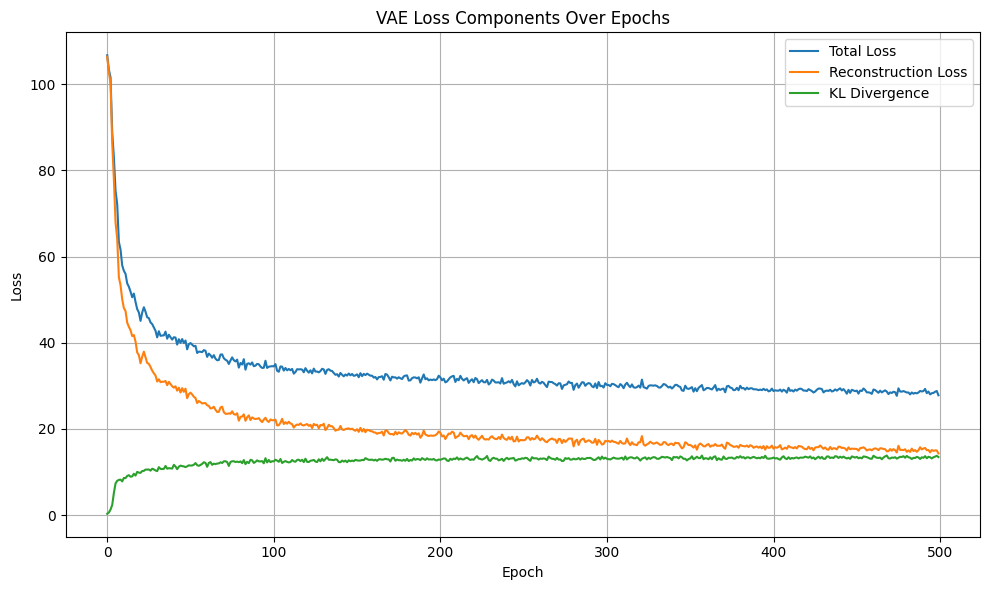

In [11]:
plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

dim of latent mu: (331, 10)


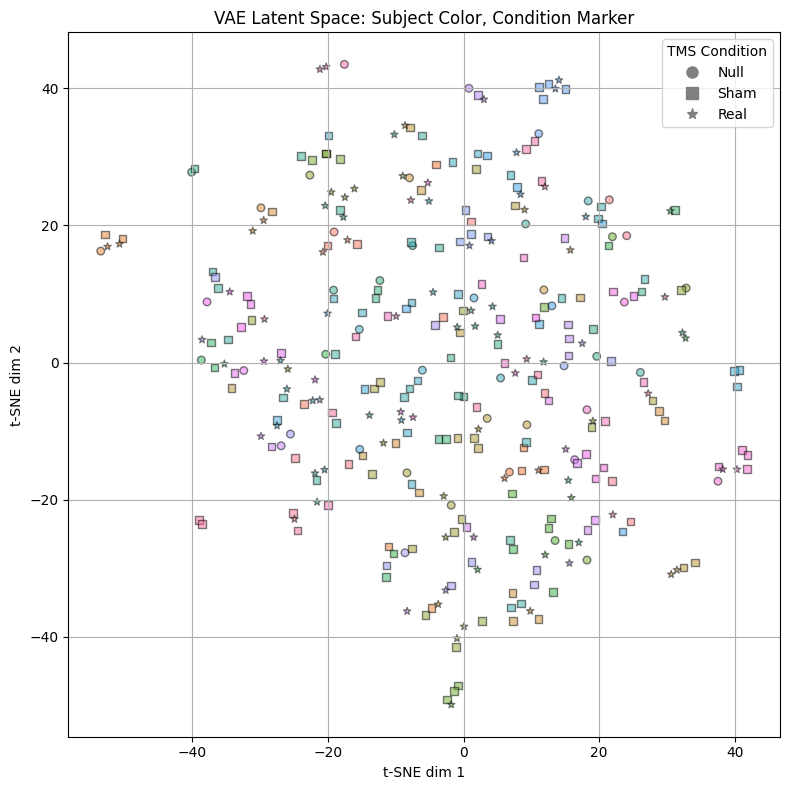

In [12]:
mu_all = get_latent_mu(model, X_tensor, device=device)
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

In [13]:
df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)
print(df.head())
print(df.describe())

     subject  d_null_sham  d_null_real  diff_real_minus_sham
0  NODEAP_06     3.592300     4.573091              0.980791
1  NODEAP_07     3.527067     4.006552              0.479485
2  NODEAP_08     2.326747     2.783874              0.457127
3  NODEAP_09     2.239866     2.018339             -0.221526
4  NODEAP_10     2.484928     2.739407              0.254479
       d_null_sham  d_null_real  diff_real_minus_sham
count    46.000000    46.000000             46.000000
mean      2.737176     3.025067              0.287892
std       0.855482     0.796702              0.685352
min       1.195865     1.348700             -1.108380
25%       2.064770     2.512624             -0.028079
50%       2.612182     2.843278              0.253495
75%       3.355412     3.576556              0.817051
max       5.378773     4.808288              2.056352


Paired t-test: t = -2.849, p = 0.0066


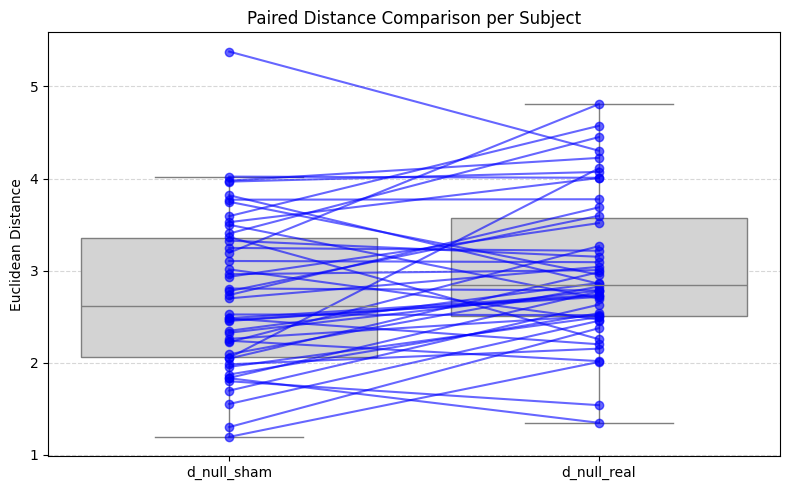

In [14]:
# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)